# processing RGE_ALTI

In [38]:
import os
import shutil
import rasterio

In [23]:
full_rge_path = "/mnt/d/rge-1m/"
local_7z_path = "./data/temp7z/"
local_ex_path = "./data/extract/"
local_pr_path = "./data/processed/"

#### Get paths of all raw 7z files:

In [3]:
rge_7z_paths = []
for root, dirs, files in os.walk(full_rge_path):
    for file in files:
        if ".7z" in file:
            rge_7z_paths.append(os.path.join(root, file))
rge_7z_paths[:5]

['/mnt/d/rge-1m/AURA/RGEALTI_2-0_1M_ASC_LAMB93-IGN69_D001_2020-11-13.7z',
 '/mnt/d/rge-1m/AURA/RGEALTI_2-0_1M_ASC_LAMB93-IGN69_D003_2021-08-25.7z',
 '/mnt/d/rge-1m/AURA/RGEALTI_2-0_1M_ASC_LAMB93-IGN69_D007_2021-11-02.7z',
 '/mnt/d/rge-1m/AURA/RGEALTI_2-0_1M_ASC_LAMB93-IGN69_D015_2019-12-10.7z',
 '/mnt/d/rge-1m/AURA/RGEALTI_2-0_1M_ASC_LAMB93-IGN69_D026_2021-11-02.7z']

#### Copy dataset on local env

In [6]:
raw_7z_path = rge_7z_paths[0]
tmp_7z_path = os.path.join(local_7z_path, os.path.basename(raw_7z_path))
#shutil.copyfile(raw_7z_path, loc_7z_path)

#### Extract the content

In [7]:
import py7zr

def extract_rge(zipfile_path, local_ex_path):
    """
    Extracts the zip DEM.
    """

    os.makedirs(local_ex_path, exist_ok = True)
    with py7zr.SevenZipFile(zipfile_path, mode='r') as archive:
        archive.extractall(path=local_ex_path) #WIN: check the path lenght in case of error FileNotFound
    print(f"{zipfile_path} is extracted to {local_ex_path}.")

#extract_rge(tmp_7z_path, local_ex_path)

./data/temp7z/RGEALTI_2-0_1M_ASC_LAMB93-IGN69_D001_2020-11-13.7z is extracted to ./data/extract/.


#### Get source paths into lists

In [8]:
def get_file_paths(extraction_path, band_type):
    """
    This funciton returns a list of paths of asc files.
    "band_type" should be one of "MNT", "DST", or "SRC"
    """
    for root, dirs, files in os.walk(extraction_path):
        if "1_DONNEES_LIVRAISON" in root and f"_{band_type}_" in root:
            local_list = sorted([os.path.join(root, file) for file in os.listdir(root)])
            return local_list

src_paths_list = get_file_paths(local_ex_path, "SRC")
mnt_paths_list = get_file_paths(local_ex_path, "MNT")
dst_paths_list = get_file_paths(local_ex_path, "DST")

#### Sampling

In [39]:
src_paths_list = src_paths_list[:2]
mnt_paths_list = mnt_paths_list[:2]
dst_paths_list = dst_paths_list[:2]

def set_raster_CRS(path, crs="EPSG:2154"):
    with rasterio.open(path, 'r+') as raster:
        raster.crs = crs

for path in src_paths_list:
    set_raster_CRS(path, crs="EPSG:2154")

for path in dst_paths_list:
    set_raster_CRS(path, crs="EPSG:2154")

#### Preprocess data to get 3 bands tiles

In [40]:
import numpy as np
from osgeo import gdal, osr

def get_header_asc(filepath):
    """
    This function reads the header of an asc file and returns 
    the data into a dictionnary
    """
    file = open(filepath)
    content = file.readlines()[:6]
    content = [item.split() for item in content]
    return dict(content)

def get_src_array(mnt_filepath):
    """
    This function reads the header of an asc file and returns 
    the data into a dictionnary
    """
    file_x = os.path.basename(mnt_filepath).split("_")[2]
    file_y = os.path.basename(mnt_filepath).split("_")[3]

    for file in src_paths_list:
        if file_x in file and file_y in file:
            src = gdal.Open(file)
            src_array = np.array(src.GetRasterBand(1).ReadAsArray())
            return src_array

def get_dst_array(filepath):
    """
    This function reads the header of an asc file and returns 
    the data into a dictionnary
    """
    file_x = os.path.basename(filepath).split("_")[2]
    file_y = os.path.basename(filepath).split("_")[3]

    for file in dst_paths_list:
        if file_x in file and file_y in file:
            dst = gdal.Open(file)
            dst_array = np.array(dst.GetRasterBand(1).ReadAsArray())
            return dst_array


class RGEitem():
    """
    This class is used to handle RGE items.
    """
    def __init__(self, filepath):
        self.filename = os.path.basename(filepath)
        self.dir = os.path.dirname(filepath)
        self.MNT = np.loadtxt(filepath, skiprows=6)
        self.SRC = get_src_array(filepath)
        self.DST = get_dst_array(filepath)
        self.header = get_header_asc(filepath)
        self.ncols = int(self.header['ncols'])
        self.nrows = int(self.header['nrows'])
        self.xllc = float(self.header['xllcorner'])
        self.yllc = float(self.header['yllcorner'])
        self.res = float(self.header['cellsize'])
        self.zmin = float(self.MNT.min())
        self.zmax = float(self.MNT.max())
        self.novalue = -99999.

def asc_to_tif(file, output_raster_dir, epsg):
    """
    Transforms an .asc file into a geoTIFF.

    Params:
    -------
    file: an RGEitem
    output_raster_dir (str): path to the directory where the tif will be saved.
    epsg (int): projection system.

    Returns:
    --------
    output_rasterpath (str): name of the output geoTIFF
    """
    xmin = file.xllc
    ymax = file.yllc + file.nrows * file.res 
    geotransform = (xmin, file.res, 0, ymax, 0, -file.res)

    output_rasterpath = os.path.join(output_raster_dir, file.filename[:-4] + ".tif")

    # Open the file
    output_raster = gdal.GetDriverByName('GTiff').Create(output_rasterpath, file.ncols, file.nrows, 3, gdal.GDT_Float32)
    # Specify the coordinates.  
    output_raster.SetGeoTransform(geotransform)
    # Establish the coordinate encoding.  
    srs = osr.SpatialReference()  
    # Specify the projection.               
    srs.ImportFromEPSG(epsg)                     
    # Export the coordinate system to the file.
    output_raster.SetProjection(srs.ExportToWkt())
    # Writes the array.   
    output_raster.GetRasterBand(1).WriteArray(file.MNT)
    output_raster.GetRasterBand(2).WriteArray(file.SRC)
    output_raster.GetRasterBand(3).WriteArray(file.DST)
    # Set nodata value.  
    output_raster.GetRasterBand(1).SetNoDataValue(file.novalue) 
    output_raster.descriptions = tuple(['mnt', 'src', 'dst'])
    output_raster.FlushCache()
    return output_rasterpath

In [41]:
os.makedirs(local_pr_path, exist_ok = True)

In [42]:
for path in mnt_paths_list:
    asc_to_tif(RGEitem(path), local_pr_path, 2154)

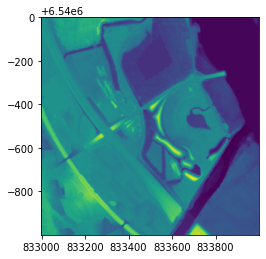

<AxesSubplot:>

In [54]:
from rasterio.plot import show
import rasterio
from matplotlib import pyplot

raster = rasterio.open("/home/guiat/dev/rge1m/data/processed/RGEALTI_FXX_0833_6540_MNT_LAMB93_IGN69.tif")

show(raster.read(1), transform=raster.transform)